# Start to end test

Before runing this test, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
import os
import sys
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
from termcolor import colored
import warnings
import time
import keras
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')
mode = "gpu"

sys.path.append(NOMEROFF_NET_DIR)

# Import license plate recognition tools.
from NomeroffNet import  filters
from NomeroffNet import  RectDetector
from NomeroffNet import  TextDetector
from NomeroffNet import  OptionsDetector
from NomeroffNet import  Detector
from NomeroffNet import  textPostprocessing
from NomeroffNet import  textPostprocessingAsync

# Initialize npdetector with default configuration file.
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel("latest")

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    }
},mode)

Using TensorFlow backend.
W0731 19:24:08.360409 140271834728064 deprecation_wrapper.py:119] From /mnt/data/var/www/html2/js/nomeroff-net_2/NomeroffNet/Detector.py:14: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0731 19:24:08.361876 140271834728064 deprecation_wrapper.py:119] From /mnt/data/var/www/html2/js/nomeroff-net_2/NomeroffNet/Detector.py:16: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0731 19:24:08.612994 140271834728064 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 19:24:08.616709 140271834728064 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 19:24:08.619274 140271834728064 deprecati

In [2]:
from NomeroffNet.Base import OCR

In [3]:

# class eu(OCR):
#     def __init__(self):
#         OCR.__init__(self)
#         # only for usage model
#         # in train generate automaticly
#         self.letters = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

#         self.EPOCHS = 1


In [4]:
# eu.load(PATH)

In [5]:
import cv2
import numpy as np

async def test(dirName, fname, y, verbose=0, max_img_w = 1000):
    img_path = os.path.join(dirName, fname)
    if verbose==1:
        print(colored(f"__________ \t\t {img_path} \t\t __________", "blue"))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    nGood = 0
    nBad = 0
    img_path = os.path.join(dirName, fname)

    # corect size for better speed
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_w_r = 1
    img_h_r = 1
    if img_w > max_img_w:
        resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
        img_w_r = img_w/max_img_w
        img_h_r = img_h/(max_img_w/img_w*img_h)
    else:
        resized_img = img

    NP = nnet.detect([resized_img]) 
    
    # Generate image mask.
    cv_img_masks = await filters.cv_img_mask_async(NP)
    if verbose:
        for m in cv_img_masks:
            plt.imshow(m)
            plt.show()
            
    # Detect points.
    arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=0, fixGeometry=True, fixRectangleAngle=10)
    arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
    arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
    
    if verbose:
        filters.draw_box(img, arrPoints, (0, 255, 0), 3)
        plt.imshow(img)
        plt.show()
    
    # cut zones
    zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
    toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
    if verbose:
        for zone, points in zip(toShowZones, arrPoints):
            plt.imshow(zone)
            plt.show()

    # find standart
    regionIds, stateIds, lines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    if verbose:
        print(regionNames)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, lines)
    textArr = await textPostprocessingAsync(textArr, regionNames)
    if verbose:
        print(textArr)
    
    for yText in y:
        if yText in textArr:
            print(colored(f"OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path}", 'green'))
            nGood += 1
        else:
            print(colored(f"NOT OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path} ", 'red'))
            nBad += 1
    return nGood, nBad

In [6]:
dirName = "./images"

__________ 		 ./images/0.jpeg 		 __________


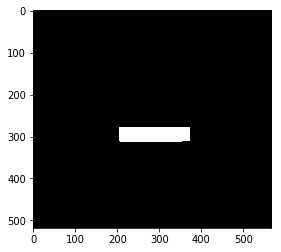

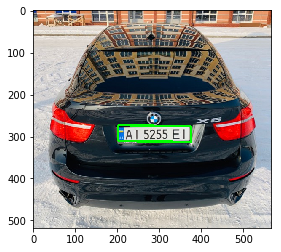

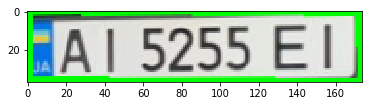

['eu_ua_2015']
['AI5255EI']
OK: TEXT:AI5255EI 			 RESULTS:['AI5255EI'] 
					 in PATH:./images/0.jpeg
__________ 		 ./images/1.jpeg 		 __________


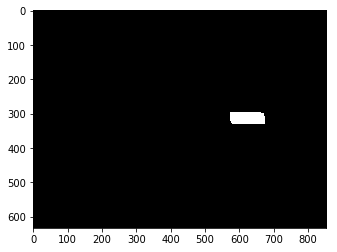

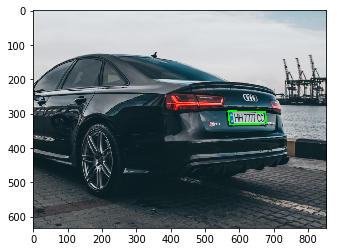

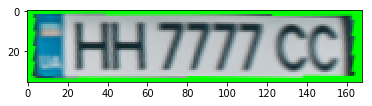

['eu_ua_2015']
['HH7777CC']
OK: TEXT:HH7777CC 			 RESULTS:['HH7777CC'] 
					 in PATH:./images/1.jpeg
__________ 		 ./images/2.jpeg 		 __________


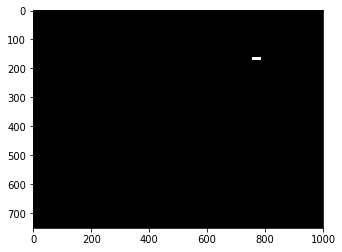

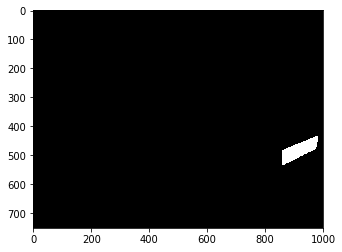

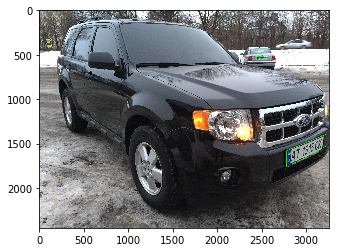

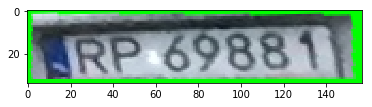

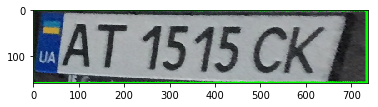

['eu', 'eu_ua_2015']
['BP69881', 'AT1515CK']
OK: TEXT:AT1515CK 			 RESULTS:['BP69881', 'AT1515CK'] 
					 in PATH:./images/2.jpeg
__________ 		 ./images/3.jpeg 		 __________


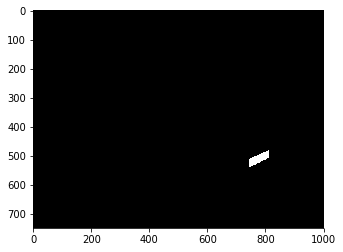

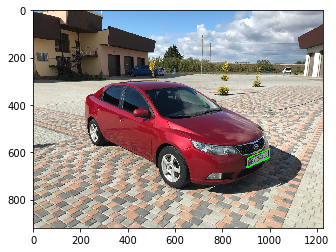

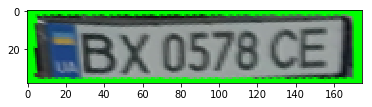

['eu_ua_2015']
['BX0578CE']
OK: TEXT:BX0578CE 			 RESULTS:['BX0578CE'] 
					 in PATH:./images/3.jpeg
__________ 		 ./images/4.jpeg 		 __________


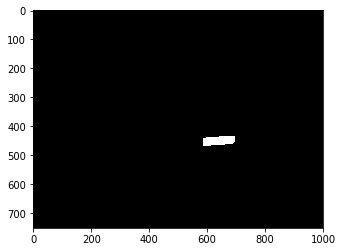

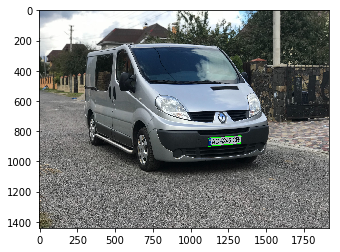

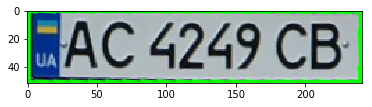

['eu_ua_2015']
['AC4249CB']
OK: TEXT:AC4249CB 			 RESULTS:['AC4249CB'] 
					 in PATH:./images/4.jpeg
__________ 		 ./images/5.jpeg 		 __________


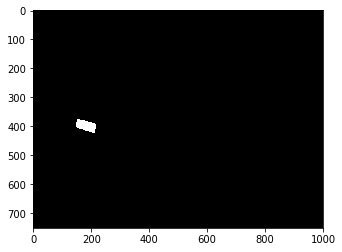

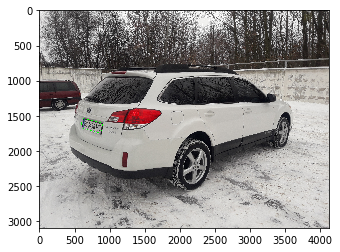

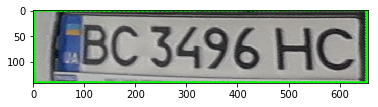

['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:./images/5.jpeg
__________ 		 ./images/6.jpeg 		 __________


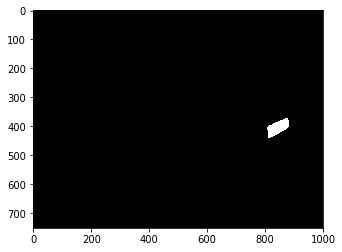

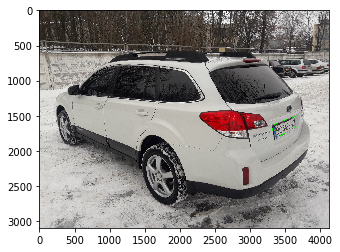

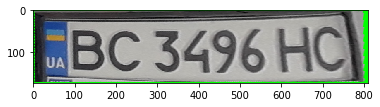

['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:./images/6.jpeg
__________ 		 ./images/7.jpeg 		 __________


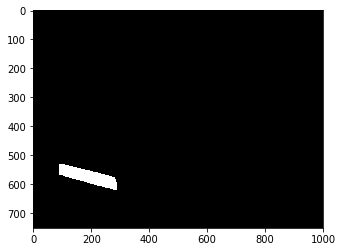

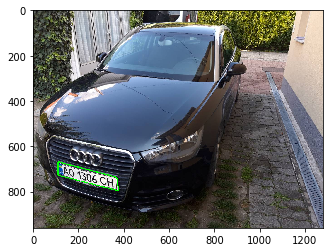

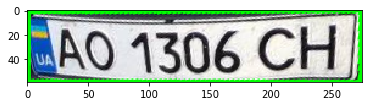

['eu_ua_2015']
['AO1306CH']
OK: TEXT:AO1306CH 			 RESULTS:['AO1306CH'] 
					 in PATH:./images/7.jpeg
__________ 		 ./images/8.jpeg 		 __________


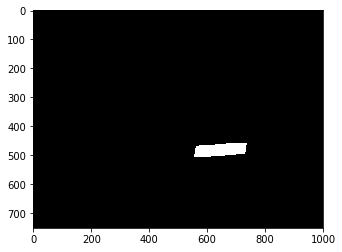

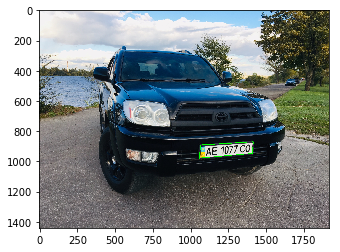

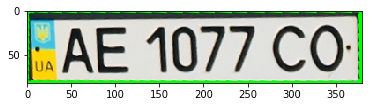

['eu_ua_2004']
['AE1077CO']
OK: TEXT:AE1077CO 			 RESULTS:['AE1077CO'] 
					 in PATH:./images/8.jpeg
__________ 		 ./images/9.jpeg 		 __________


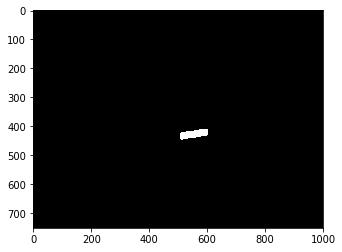

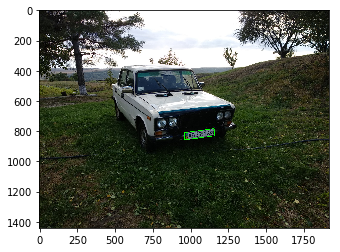

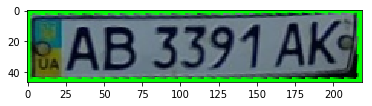

['eu_ua_2004']
['AB3391AK']
OK: TEXT:AB3391AK 			 RESULTS:['AB3391AK'] 
					 in PATH:./images/9.jpeg
__________ 		 ./images/10.jpeg 		 __________


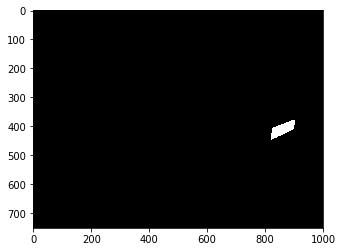

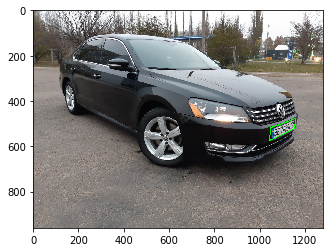

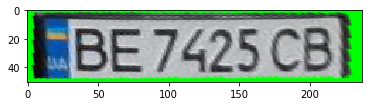

['eu_ua_2015']
['BE7425CB']
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:./images/10.jpeg
__________ 		 ./images/11.jpeg 		 __________


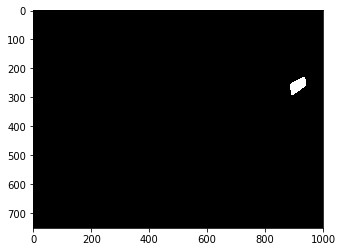

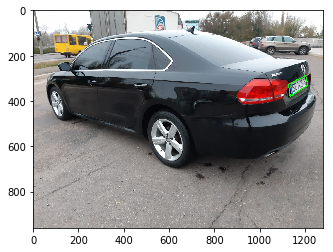

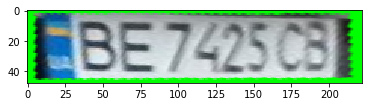

['eu_ua_2015']
['BE7425CB']
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:./images/11.jpeg
__________ 		 ./images/12.jpeg 		 __________


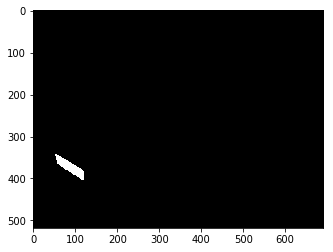

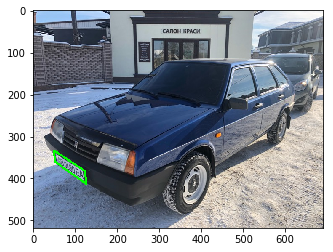

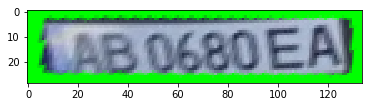

['eu_ua_2015']
['AB0680EA']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA'] 
					 in PATH:./images/12.jpeg
__________ 		 ./images/13.jpeg 		 __________


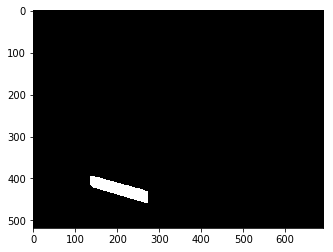

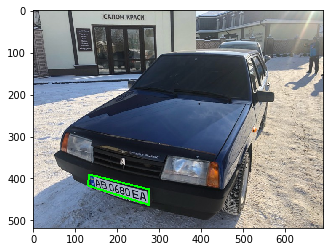

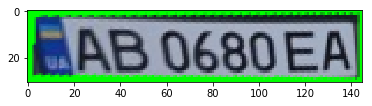

['eu_ua_2015']
['AB0680EA']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA'] 
					 in PATH:./images/13.jpeg
__________ 		 ./images/14.jpeg 		 __________


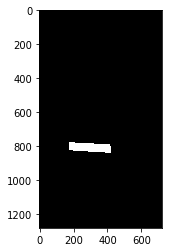

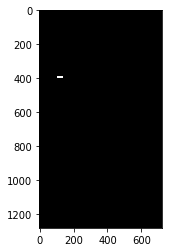

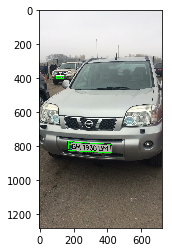

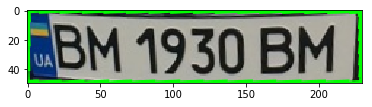

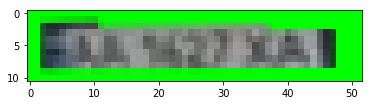

['eu_ua_2015', 'xx_unknown']
['BM1930BM', '']
OK: TEXT:BM1930BM 			 RESULTS:['BM1930BM', ''] 
					 in PATH:./images/14.jpeg
__________ 		 ./images/15.jpeg 		 __________


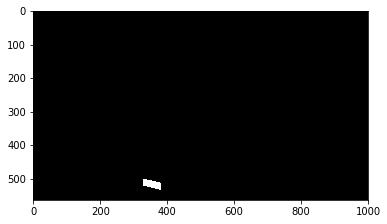

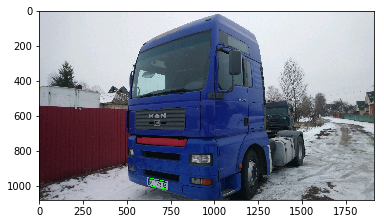

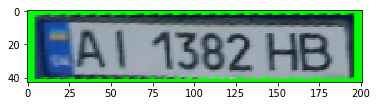

['eu_ua_2015']
['AI1382HB']
OK: TEXT:AI1382HB 			 RESULTS:['AI1382HB'] 
					 in PATH:./images/15.jpeg
__________ 		 ./images/16.jpeg 		 __________


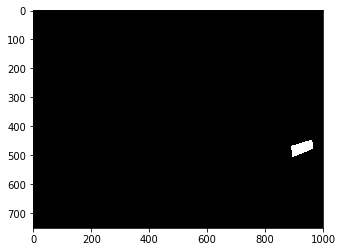

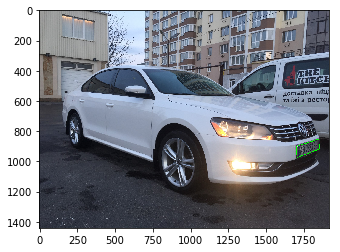

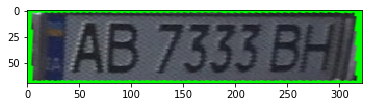

['eu_ua_2015']
['AB7333BH']
OK: TEXT:AB7333BH 			 RESULTS:['AB7333BH'] 
					 in PATH:./images/16.jpeg
__________ 		 ./images/17.jpeg 		 __________


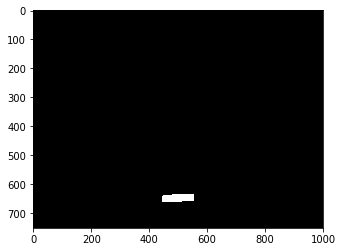

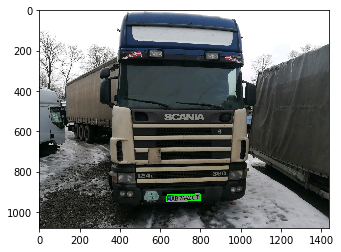

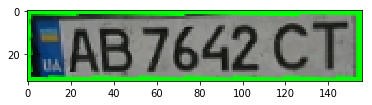

['eu_ua_2015']
['AB7642CT']
OK: TEXT:AB7642CT 			 RESULTS:['AB7642CT'] 
					 in PATH:./images/17.jpeg
__________ 		 ./images/18.jpeg 		 __________


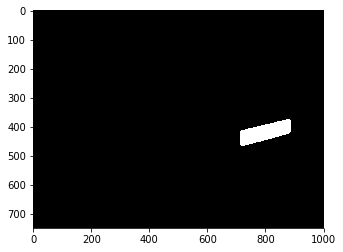

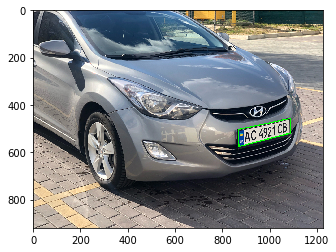

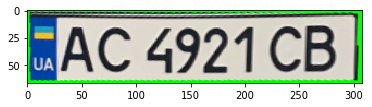

['eu_ua_2015']
['AC4921CB']
OK: TEXT:AC4921CB 			 RESULTS:['AC4921CB'] 
					 in PATH:./images/18.jpeg
__________ 		 ./images/19.jpeg 		 __________


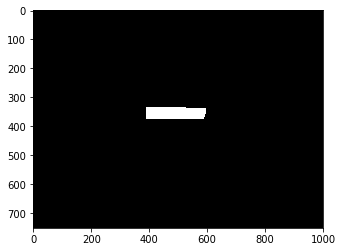

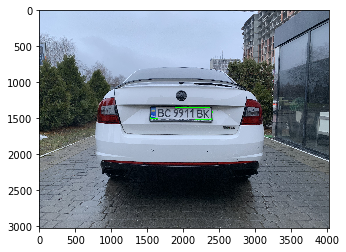

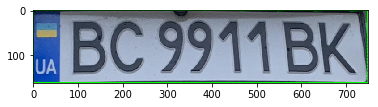

['eu_ua_2015']
['BC9911BK']
OK: TEXT:BC9911BK 			 RESULTS:['BC9911BK'] 
					 in PATH:./images/19.jpeg
__________ 		 ./images/20.jpeg 		 __________


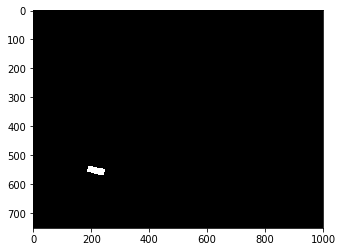

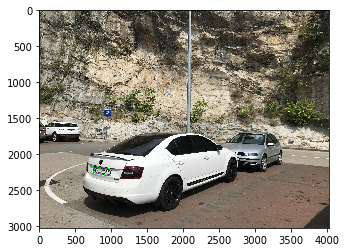

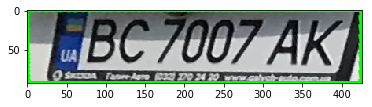

['eu_ua_2015']
['BC7007AK']
OK: TEXT:BC7007AK 			 RESULTS:['BC7007AK'] 
					 in PATH:./images/20.jpeg
__________ 		 ./images/21.jpeg 		 __________


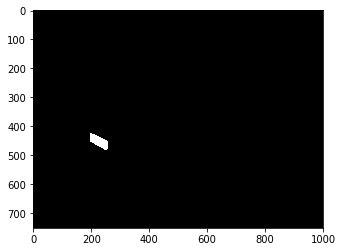

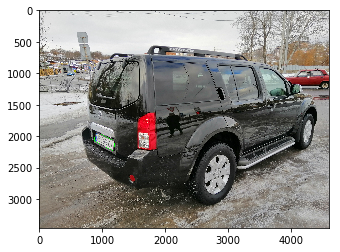

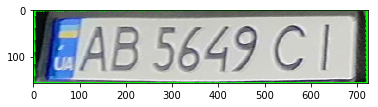

['eu_ua_2015']
['AB5649CI']
OK: TEXT:AB5649CI 			 RESULTS:['AB5649CI'] 
					 in PATH:./images/21.jpeg
__________ 		 ./images/22.jpeg 		 __________


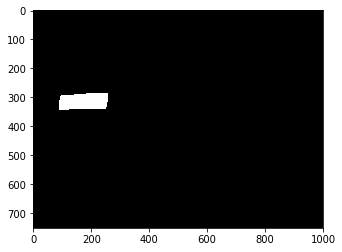

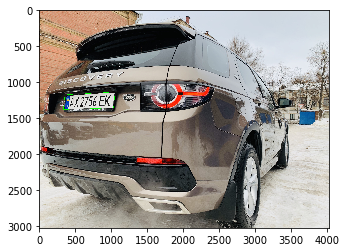

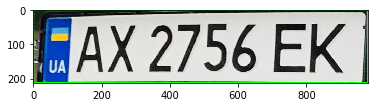

['eu_ua_2015']
['AX2756EK']
OK: TEXT:AX2756EK 			 RESULTS:['AX2756EK'] 
					 in PATH:./images/22.jpeg
__________ 		 ./images/23.jpeg 		 __________


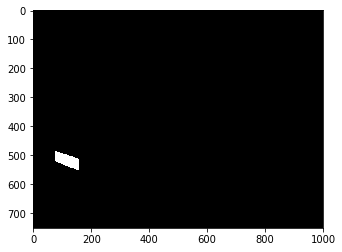

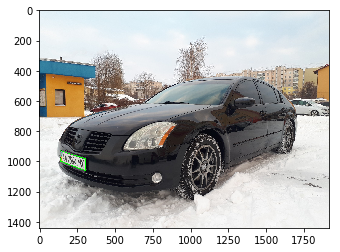

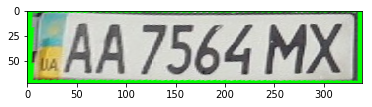

['eu_ua_2004']
['AA7564MX']
OK: TEXT:AA7564MX 			 RESULTS:['AA7564MX'] 
					 in PATH:./images/23.jpeg
__________ 		 ./images/24.jpeg 		 __________


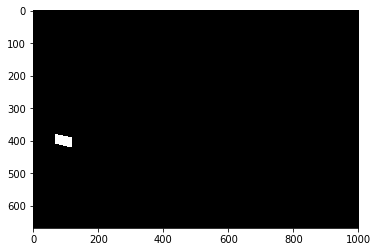

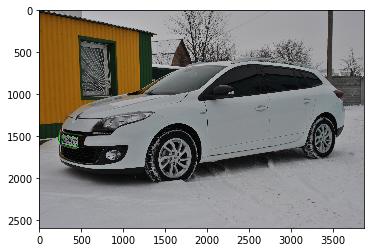

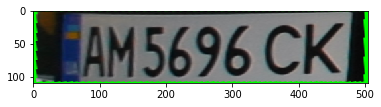

['eu_ua_2015']
['AM5696CK']
OK: TEXT:AM5696CK 			 RESULTS:['AM5696CK'] 
					 in PATH:./images/24.jpeg
__________ 		 ./images/25.jpeg 		 __________


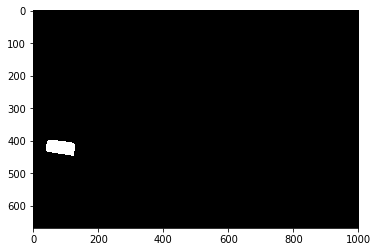

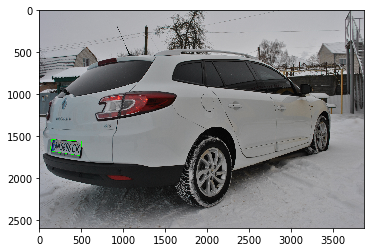

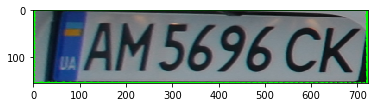

['eu_ua_2015']
['AM5696CK']
OK: TEXT:AM5696CK 			 RESULTS:['AM5696CK'] 
					 in PATH:./images/25.jpeg
TOTAL GOOD: 1.0
TOTAL BED: 0.0


In [7]:
testData = {
    "0.jpeg": ["AI5255EI"],
    "1.jpeg": ["HH7777CC"],
    "2.jpeg": ["AT1515CK"],
    "3.jpeg": ["BX0578CE"],
    "4.jpeg": ["AC4249CB"],
    "5.jpeg": ["BC3496HC"],
    "6.jpeg": ["BC3496HC"],
    "7.jpeg": ["AO1306CH"],
    "8.jpeg": ["AE1077CO"],
    "9.jpeg": ["AB3391AK"],
    "10.jpeg": ["BE7425CB"],
    "11.jpeg": ["BE7425CB"],
    "12.jpeg": ["AB0680EA"],
    "13.jpeg": ["AB0680EA"],
    "14.jpeg": ["BM1930BM"],
    "15.jpeg": ["AI1382HB"],
    "16.jpeg": ["AB7333BH"],
    "17.jpeg": ["AB7642CT"],
    "18.jpeg": ["AC4921CB"],
    "19.jpeg": ["BC9911BK"],
    "20.jpeg": ["BC7007AK"],
    "21.jpeg": ["AB5649CI"],
    "22.jpeg": ["AX2756EK"],
    "23.jpeg": ["AA7564MX"],
    "24.jpeg": ["AM5696CK"],
    "25.jpeg": ["AM5696CK"],
}

gGood = 0
gBad = 0
i = 0
for fileName in testData.keys():
    nGood, nBad = await test(dirName, fileName, testData[fileName], verbose=1)
    gGood += nGood
    gBad += nBad
    i += 1
total = gGood + gBad
print(f"TOTAL GOOD: {gGood/total}")
print(f"TOTAL BED: {gBad/total}")

__________ 		 ./images/12.jpeg 		 __________


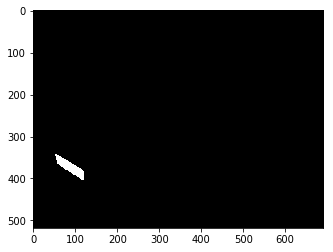

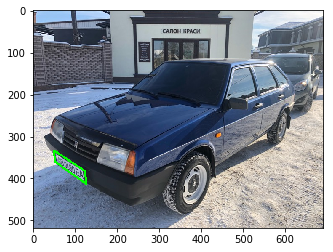

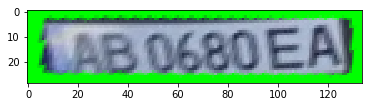

['eu_ua_2015']
['AB0680EA']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA'] 
					 in PATH:./images/12.jpeg


(1, 0)

In [8]:
await test(dirName, "12.jpeg", ["AB0680EA"], verbose=1, max_img_w = 1200)